In [1]:
#创建SparkSession
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
spark = SparkSession.builder.appName('data_processing').getOrCreate()

In [2]:
#读入数据
# df = spark.read.csv('C:/Users/REGGIE/Desktop/student/数据分析资料/Spark学习/data/telecom_churn.csv',inferSchema=True,header=True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('C:/Users/REGGIE/Desktop/student/数据分析资料/Spark学习/data/telecom_churn.csv')

In [5]:
# # 首先进行自变量与因变量之间的关系
# df.columns
# df.churn.value_counts()
# #分类变量与分类变量
# sns.boxplot(x = 'gender', y = 'churn',data = df)

# #分类变量与连续变量
# plt.figure(figsize=(20,5))

# df.churn.groupby(df.AGE).sum().plot(kind = 'bar')

In [6]:
# #分类变量与分类变量
# #交叉表
# pd.crosstab(df.edu_class,df.churn).plot(kind = 'bar')

In [7]:
# ##  分类变量的相关关系
#
# 交叉表
#两变量分析：检验该用户通话时长是否呈现出上升态势(posTrend)对流失(churn) 是否有预测价值
cross_table = pd.crosstab(df.posTrend, df.churn, margins=True)
cross_table
#呈现上升趋势的时候流失客户较少，所以有预测价值

churn,0.0,1.0,All
posTrend,,,
0.0,829,990,1819
1.0,1100,544,1644
All,1929,1534,3463


In [8]:
candidates = ['churn','duration','AGE','edu_class','posTrend','negTrend','nrProm','prom','curPlan','avgplan','planChange','incomeCode','feton','peakMinAv','peakMinDiff','call_10086']
data_for_select = df[candidates]
#%%
def vif(df, col_i):
    from statsmodels.formula.api import ols
    
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

exog = df[candidates].drop(['churn'], axis=1)

for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))

duration 	 1.1651943339038737
AGE 	 1.0595356320253755
edu_class 	 1.0960381728685262
posTrend 	 11.071390844640687
negTrend 	 10.965934864380682
nrProm 	 10.940661958600174
prom 	 10.991026222137762
curPlan 	 242.49161771953592
avgplan 	 239.39277858354083
planChange 	 3.2381781601285033
incomeCode 	 1.0283743532179408
feton 	 1.0367197705077769
peakMinAv 	 1.2493847445837658
peakMinDiff 	 1.732123838870938
call_10086 	 1.0242622323807176


In [9]:
#vif 大于10，并且两个变量之间的vif接近就代表具有强共线性
#posTrend,negTrend;curPlan,avgplan,nrProm,prom有明显的共线性问题,剔除他们具有强共线性中的一个重新建模.
#%%
final_data = ['duration','AGE','edu_class','posTrend','nrProm','curPlan','planChange','incomeCode','feton','peakMinAv','peakMinDiff','call_10086','churn']
data_for_select = df[final_data]

In [10]:
#%%
#先转化为spark——df
sc = SparkContext.getOrCreate();
sqlContest = SQLContext(sc)
df = sqlContest.createDataFrame(data_for_select)

In [11]:
#特征处理
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.linalg import Vectors
data=df.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
data.show()
#随机抽样，建立训练集与测试集
train_df,test_df=data.randomSplit([0.75,0.25])
print(train_df.count(),test_df.count())

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[16.0,20.0,2.0,0....|  1.0|
|[5.0,20.0,0.0,0.0...|  1.0|
|[3.0,11.0,1.0,0.0...|  1.0|
|[12.0,43.0,0.0,0....|  1.0|
|[14.0,60.0,0.0,0....|  1.0|
|[9.0,20.0,2.0,1.0...|  0.0|
|[5.0,17.0,2.0,0.0...|  1.0|
|[7.0,45.0,2.0,0.0...|  1.0|
|[5.0,36.0,0.0,1.0...|  1.0|
|[17.0,17.0,2.0,0....|  1.0|
|[10.0,10.0,1.0,0....|  0.0|
|[21.0,15.0,1.0,1....|  0.0|
|[10.0,43.0,1.0,0....|  0.0|
|[16.0,59.0,3.0,0....|  1.0|
|[24.0,11.0,0.0,1....|  0.0|
|[15.0,41.0,3.0,0....|  0.0|
|[3.0,35.0,0.0,0.0...|  1.0|
|[4.0,38.0,1.0,0.0...|  1.0|
|[8.0,18.0,0.0,0.0...|  1.0|
|[23.0,46.0,0.0,0....|  0.0|
+--------------------+-----+
only showing top 20 rows

2606 857


In [12]:
train_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0,14.0,0.0,0.0...|  1.0|
|[2.0,16.0,0.0,0.0...|  1.0|
|[2.0,21.0,0.0,0.0...|  1.0|
|[2.0,23.0,1.0,0.0...|  1.0|
|[2.0,24.0,0.0,1.0...|  1.0|
|[2.0,25.0,0.0,0.0...|  1.0|
|[2.0,27.0,0.0,1.0...|  1.0|
|[2.0,34.0,0.0,0.0...|  1.0|
|[2.0,38.0,1.0,0.0...|  1.0|
|[2.0,39.0,0.0,0.0...|  1.0|
|[2.0,46.0,0.0,0.0...|  1.0|
|[3.0,11.0,1.0,0.0...|  1.0|
|[3.0,14.0,0.0,0.0...|  1.0|
|[3.0,14.0,0.0,1.0...|  1.0|
|[3.0,14.0,2.0,0.0...|  1.0|
|[3.0,14.0,3.0,1.0...|  1.0|
|[3.0,21.0,0.0,1.0...|  1.0|
|[3.0,21.0,1.0,1.0...|  1.0|
|[3.0,24.0,1.0,0.0...|  1.0|
|[3.0,28.0,1.0,0.0...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [14]:
# 逻辑回归
from pyspark.ml.classification import LogisticRegression
blor = LogisticRegression(regParam=0.01,labelCol='label')
blorModel = blor.fit(train_df)

In [15]:
#进行预测
blorModel_predict=blorModel.transform(test_df)
blorModel_predict.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[2.0,32.0,1.0,1.0...|  1.0|[-1.8601856911800...|[0.13468140960162...|       1.0|
|[3.0,13.0,2.0,0.0...|  1.0|[-2.9083479808733...|[0.05174243203808...|       1.0|
|[3.0,15.0,0.0,0.0...|  1.0|[-0.9046850401154...|[0.28808867252879...|       1.0|
|[3.0,19.0,1.0,0.0...|  1.0|[-1.9696358822105...|[0.12242800203688...|       1.0|
|[3.0,20.0,0.0,1.0...|  1.0|[-0.5637585336258...|[0.36267825436630...|       1.0|
|[3.0,22.0,0.0,1.0...|  1.0|[-1.1648214977410...|[0.23779229807914...|       1.0|
|[3.0,25.0,0.0,0.0...|  1.0|[-3.7763584161695...|[0.02239302019698...|       1.0|
|[3.0,35.0,0.0,0.0...|  1.0|[-0.9292057274389...|[0.28308588296988...|       1.0|
|[3.0,35.0,0.0,1.0...|  1.0|[-1.2929084349431...|[0.21536093487834...|       1.0|
|[3.0,39.0,0.0,0

In [16]:
# 模型效果
blorModel_predict.groupBy('prediction').count().show()
blorModel_predict.select(['probability','label','prediction']).show(10,False)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  457|
|       1.0|  400|
+----------+-----+

+-----------------------------------------+-----+----------+
|probability                              |label|prediction|
+-----------------------------------------+-----+----------+
|[0.13468140960162658,0.8653185903983736] |1.0  |1.0       |
|[0.051742432038085956,0.948257567961914] |1.0  |1.0       |
|[0.28808867252879,0.71191132747121]      |1.0  |1.0       |
|[0.12242800203688628,0.8775719979631138] |1.0  |1.0       |
|[0.362678254366309,0.637321745633691]    |1.0  |1.0       |
|[0.2377922980791441,0.7622077019208559]  |1.0  |1.0       |
|[0.022393020196987436,0.9776069798030126]|1.0  |1.0       |
|[0.2830858829698819,0.716914117030118]   |1.0  |1.0       |
|[0.21536093487834088,0.7846390651216592] |1.0  |1.0       |
|[0.179858267625548,0.820141732374452]    |1.0  |1.0       |
+-----------------------------------------+-----+----------+
only showing top 10 rows



In [17]:
#模型摘要
trainingSummary = blorModel.summary

In [18]:
print("Multinomial coefficients: " + str(blorModel.coefficientMatrix))  #系数矩阵
print("Multinomial intercepts: " + str(blorModel.interceptVector))  #截距向量

Multinomial coefficients: DenseMatrix([[-1.86886066e-01, -2.16947785e-02,  2.12143560e-01,
              -3.52630591e-01,  6.93617469e-02,  1.00287136e-01,
              -2.78041212e-02,  9.79236285e-03, -9.75983391e-01,
               3.70730947e-04, -2.02462897e-03, -6.07331296e-01]])
Multinomial intercepts: [2.818890505165656]


In [19]:
#在每次迭代中获取对象
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

objectiveHistory:
0.6865062799266008
0.6267714886603852
0.5475460529873861
0.4770905687981582
0.4655025879639753
0.4417862853094657
0.42986537364100813
0.42584437671581526
0.42371353744469126
0.4204761196522092
0.4176510484782228
0.4134370306355357
0.4128490723323663
0.4099030637454474
0.40851853180649605
0.4083631324946812
0.40830669827946187
0.408300164732556
0.4082908944180581
0.40827799979881785
0.4082718898887562
0.40827134540951443
0.4082712529733043
0.4082712382891198
0.4082712378749407
0.4082712377412185
0.408271237528665
0.40827123749026245
0.40827123747502614
0.4082712374602645
0.40827123745953625
0.40827123745609484
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.022549869904596703|
|                 0.0|0.045099739809193407|
|                 0.0| 0.06764960971379011|
|6.882312456985547E-4| 0.08933217692974849|
|6.8823124569

In [20]:
#模型重要指标
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8158096699923254
FPR: 0.1837656709449855
TPR: 0.8158096699923254
F-measure: 0.8162035642794699
Precision: 0.8174635806846644
Recall: 0.8158096699923254


In [21]:
#尝试使用sklearn中的逻辑回归
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('C:/Users/REGGIE/Desktop/student/数据分析资料/Spark学习/data/telecom_churn.csv')

In [23]:
#使用向前逐步法从其它备选变量中选择变量，构建基于AIC的最优模型，绘制ROC曲线，同时检验模型的膨胀系数
#- 多元逻辑回归
# 向前法
def forward_select(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            aic = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(sm.families.links.logit)
            ).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score > best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('aic is {},continuing!'.format(current_score))
        else:        
            print ('forward selection over!')
            break
            
    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = smf.glm(
        formula=formula, data=data, 
        family=sm.families.Binomial(sm.families.links.logit)
    ).fit()
    return(model)


lg_m1 = forward_select(data=data_for_select, response='churn')
# lg_m1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  app.launch_new_instance()


aic is 3036.3006938313874,continuing!
aic is 2873.2351242989025,continuing!
aic is 2766.544896842034,continuing!
aic is 2704.939493661153,continuing!
aic is 2660.232115098335,continuing!
aic is 2616.7385945696665,continuing!
aic is 2608.1534288330195,continuing!
aic is 2601.7772457332803,continuing!
aic is 2599.1387103247707,continuing!
forward selection over!
final formula is churn ~ duration + feton + peakMinDiff + call_10086 + edu_class + AGE + posTrend + incomeCode + curPlan 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.


In [24]:
final_data = ['duration','AGE','edu_class','posTrend','curPlan','incomeCode','feton','peakMinDiff','call_10086']

In [25]:
from sklearn.model_selection import train_test_split
X = df[final_data]
y = df['churn']
#随机抽样，建立训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42) 
# print(X_train, X_test, y_train, y_test)

In [26]:
# # 标准化
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

In [27]:
#建立模型
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()
lr = LogisticRegression()
lr_pipe = make_pipeline(scaler,lr)
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [28]:
#Make predictions
y_pred = lr_pipe.predict(X_test) 
#Save the prediction results to the dataframe
df = pd.DataFrame(X_test) 
df['y_test']=y_test
df['pred']=y_pred
label = [0,1]

In [30]:
# df

In [31]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,labels=label))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       469
           1       0.79      0.80      0.80       397

    accuracy                           0.81       866
   macro avg       0.81      0.81      0.81       866
weighted avg       0.81      0.81      0.81       866



In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8100787892133432

[[383  86]
 [ 78 319]]


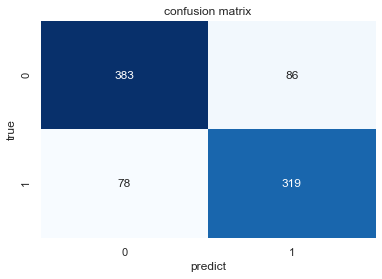

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_test, y_pred, labels=[0, 1])
print(C2) 

#Heat map
sns.heatmap(C2,annot=True,ax=ax,cbar = None, cmap = 'Blues', fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')
plt.show()

In [34]:
from sklearn.externals import joblib
# Save to sklearn's own file format
joblib.dump(lr_pipe, 'lr_pipe.pkl')

C:\Users\REGGIE\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['lr_pipe.pkl']